Suported Vector Machine (SVM)
=============================

O objetivo, nesse notebook, é `treinar` um modelo do tipo `SVM` com a biblioteca `sklearn` com bons `hiperparâmetros` e avaliar seus _resultados_. De forma mais expecífica, busca-se obter um modelo com os `hiperparâmetros` _otimizados_, assim como realizar a estratégia de _validação cruzada_ e, ao final, obter uma `métrica` de desempenho do modelo. Nesse sentido, os passos serão os seguintes:

1. Utilizar o módulo Optuna para realizar, por meio de validação cruzada, a otimização de hiperparâmetros; com base no conjunto de treino.

2. Treinar um modelo, dito oficial, com os hiperparâmetros otimizados.

3. Obter a medida de desempenho do modelo realizando o teste com o conjunto de teste, previamente separado.

OBS: Para o sklearn o SVM que se enquadra no problema de classificação é o Supported Vector Classification (SVC)

Esse modelo tem, como forma de funcionamento simplificado, a ideia de criar um hiperplano que divida o espaço entre duas ou mais classes. O hiperplano é uma figura com uma dimensão a menos que o espaço em que está inserido. Por meio de funções de maximização, ele tenta criar o hiperplano que fique mais distante das duas classes, ainda as separando. Para problemas mais complexos, é possível realizar a estratégia de kernel e aumentar as dimensões do espaço, possibilitando separar as diferentes classes por meio do hiperplano.

In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

## Importando os dados de treino

Como discutido no notebook que realizou o tratamento geral dos dados, seu retorno seriam 4 arquivos .csv que poderiam ser importados em outros notebooks. Aqui, importo, por hora, apenas os dados que serão utilizados para treino.

X é o conjunto de features. Uma lista de listas (arrey numpy).

y é o conjunto de dados dos targets. Uma lista (arrey numpy).

In [2]:
X_original = pd.read_csv('Features para treino.csv', index_col='Unnamed: 0', sep=',').to_numpy()
y_original = pd.read_csv('Target para treino.csv', index_col='Unnamed: 0', sep=',' ).to_numpy().reshape(-1)

le = LabelEncoder()
y_original = le.fit_transform(y_original)  # 'Control'->0, 'Impaired'->1

## Selecionar os atributos

Dado que temos muitas colunas no dataset, é de interesse selecionar apenas algumas delas para utilisar. Além disso, dado a origem biológica do dataset e sua proposta no âmbito de uma medida abrangente, há, provavelmente, muitas colunas que não são tão impactantes no desempenho final quanto outras. Em razão disso, faremos a seleção de atributos.

Ela será realizada com a métrica de f1 pois essa prioriza acertos na classe Impaires, que deve ser o foco. Ao maximizar essa métrica, caminha-se na direção de criar um modelo que priorize essa classe.

In [ ]:
seletor_atributos = SequentialFeatureSelector(
    estimator=SVC(),
    n_features_to_select='auto',
    direction='forward',
    scoring='f1',
    cv=5,
    n_jobs=-1
)

seletor_atributos.fit(X_original, y_original)

,estimator,SVC()
,n_features_to_select,'auto'
,tol,None
,direction,'forward'
,scoring,'f1'
,cv,5
,n_jobs,-1
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'


### Tendo eles selecionados

In [4]:
X = seletor_atributos.transform(X_original)
y = y_original

## Otimização de hiperparâmetros

Cada `algoritmo` de aprendizado de máquina possui o que é chamado `hiperparâmetro`. Estes são definidos pelo _operador_ antes de o modelo ser _induzido_. Controlam características importantes do treinamento do modelo. É necessário diferenciar `hiperparâmetro` de `parâmetro`, que é o que o modelo aprenderá com os dados de `treino`. [1]

Para realizar a `otimização` será utilizado o módulo `optuna`, uma biblioteca com foco em encontrar, dado um espaço de busca, um bom conjunto de hiperprãmetros. O primeiro passo, então, é definir o espaço de busca. Para cada hiperparâmetro do modelo é possível pedir ao `optuna` que selecione, dado um _range_ de possibilidades, um valor para aplicar no treinamento.

### `Instanciando` o modelo

As funções abaixo criam o que é chamado `instância` do modelo, no casso desse notebook um SVC. Ela tem como parâmetro um objeto do optuna "trial", responsável por realizar as escolhas de hiperparâmetros. Na função, cada hiperparâmetro do modelo, que se julgou interessante _otimizar_, recebe o objeto "trial" com a função de sortear uma `categoria`, um objeto de `ponto` `flutuante`, ou um `inteiro`.

Ponto importante é que, no caso expecífico do SVC, o hiperparâmetro "gamma" pode receber tanto `strings`: "scale" e "auto" como pode receber um `float`. Além disso, hiperparâmetros como "degree e "coef0" são ignorados para algumas configurações de "kernel". Para esses casos há os _blocos condicionais_.

Ao final, o modelo é instanciado com os hiperparâmetros definidos anteriormente.

Vale ressaltar que uma importante estratégia ao trinar modelos é `normalizar` os dados. Isso pode ser bom o ruim. Para descobrir se é `necessário`, pode-se criar um _bloco condicional_ e testar o modelo com dados normalizados e não normalizados. A normalização é, por facilidade, realizada em uma `pipeline`, que permite condensar organizar as linhas de código.

#### Funções de suporte

Para organizar o código da função que instanciará o modelo, criou-se uma função para definir os parâmetros do SVC.

In [5]:
def parametros_SVC(trial):
    
    parametros = {}

        # C
    parametros['C'] = trial.suggest_float('Par. regular', 1e-2, 1, log=True)

        # kernel
    parametros['kernel'] = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])

        # gamma
    tipo_gamma = trial.suggest_categorical('Tipo de gamma', ['Categórico', 'Numérico'])
    # Decide qual usar
    if tipo_gamma == 'Categórico':
        parametros['gamma'] = trial.suggest_categorical('gamma_categ', ['scale', 'auto'])
    else:
        parametros['gamma'] = trial.suggest_float('gamma_num', 1e-3, 5, log=True)
    
    # Define os parâmetros 'degree' e 'coef0'. Estes são ignorados em alguns modos de kernel, não sendo necessário testá-los (basta usar o padrão)
    if parametros['kernel'] == 'poly':
        parametros['degree'] = trial.suggest_int('degree', 2, 7)
        parametros['coef0'] = trial.suggest_float('coef0', -4.0, 2.0)
    elif parametros['kernel'] == 'sigmoid':
        parametros['degree'] = 3  # Padrão
        parametros['coef0'] = trial.suggest_float('coef0', -4.0, 2.0)
    else:
        parametros['degree'] = 3 # Padrão
        parametros['coef0'] = 0 # Padrão

    return parametros

#### Função de instância

In [6]:
def instancia_modelo(trial, X):


    parametros = parametros_SVC(trial)
    modelo = SVC(
        C=parametros['C'],
        kernel=parametros['kernel'],
        gamma=parametros['gamma'],
        degree=parametros['degree'],
        coef0=parametros['coef0']
    )

    normalizar = trial.suggest_categorical('Normalizar', [True, False])


    passo_de_normalizacao = ('normalizador', StandardScaler()) if normalizar else ('normalizador', 'passthrough')
    passo_do_SVC= ('SVC', modelo)

    passos = [
        passo_de_normalizacao,
        passo_do_SVC
    ]

    pipeline = Pipeline(passos)
    
    return pipeline

### A função objetivo

Essa função é a que agrupa o modelo, os dados e qual será a `métrica` utilizada para estimar o desempenho do modelo. Tem esse nome pois represente o objetivo de, no caso desse notebook, `maximização` da métrica `f1_macro`. Seu retorno é a `média` das métricas obtidas ao realizar a `validação cruzada`, sendo esta uma _estimativa do desempenho_ do modelo, e _não_ seu desempenho real_.

In [7]:
def objetivo(trial, X, y, folds):
    
    modelo = instancia_modelo(trial, X)

    lista_metricas = cross_val_score(
        modelo,
        X,
        y,
        scoring='f1',
        cv=folds,
    )

    return lista_metricas.mean()

### O estudo do `optuna`

Antes de otimizar os `hiperparâmetros`, cria-se um estudo. Este tem a função de `armazenar` os dados que já foram testados e as métricas obtidas em cada teste. Além disso, é possível criar um arquivo de _banco de dados_ que guarda as informações sobre o teste. Assim, será criado um arquivo com nome: "`Estudo_SVC`". Esse arquivo pode ser útil, também para recuperar o que já foi realizado em caso de o computador desligar, por exemplo.

In [8]:
from optuna import create_study

nome_estudo = 'Estudo_SVC_final'

estudo = create_study(
    direction='maximize',
    study_name=nome_estudo,
    storage=f"sqlite:///{nome_estudo}.db",
    load_if_exists=True,
)

c:\venvs\quest4_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-11-03 21:45:14,914] Using an existing study with name 'Estudo_SVC_final' instead of creating a new one.


### Otimizar

Com as funções definidas basta iniciar a `otimização`. O único detalhe é que o `optuna` aceita em sua função `optimize` apenas uma função de um `argumento`, o argumento `trial`. Para contornar essa situação, cria-se a função nomeada de "`objetivo_parcial`". Ela recebe apenas o `argumento` `trial` e _retorna a função objetivo_.

Feita essa função, basta otimizar. Defini-se o número de folds que serão utilizados na validação cruzada (escolhida para gerar a estimativa da métrica), nesse caso, definida como 5. E o número de tentativas que serão realizadas, neste caso, 1000. 

In [10]:
folds = 5

def objetivo_parcial(trial):
    return objetivo(trial, X, y, folds)

In [11]:
tentativas = 10

estudo.optimize(objetivo_parcial, n_trials=tentativas, n_jobs=7) # Realiza a otimização

[I 2025-11-03 21:45:17,473] Trial 1003 finished with value: 0.742375478927203 and parameters: {'Par. regular': 0.3953326861921481, 'kernel': 'linear', 'Tipo de gamma': 'Categórico', 'gamma_categ': 'auto', 'Normalizar': False}. Best is trial 83 with value: 0.742375478927203.
[I 2025-11-03 21:45:17,653] Trial 1004 finished with value: 0.742375478927203 and parameters: {'Par. regular': 0.39407966784810816, 'kernel': 'linear', 'Tipo de gamma': 'Categórico', 'gamma_categ': 'auto', 'Normalizar': False}. Best is trial 83 with value: 0.742375478927203.
[I 2025-11-03 21:45:17,820] Trial 1001 finished with value: 0.742375478927203 and parameters: {'Par. regular': 0.39570790635068015, 'kernel': 'linear', 'Tipo de gamma': 'Categórico', 'gamma_categ': 'auto', 'Normalizar': False}. Best is trial 83 with value: 0.742375478927203.
[I 2025-11-03 21:45:17,993] Trial 1000 finished with value: 0.742375478927203 and parameters: {'Par. regular': 0.40047774399816927, 'kernel': 'linear', 'Tipo de gamma': 'Cat

### Resultado

Após a finalização da otimizaçõa é possível vizualizar os dados em forma de `Dataframe`, como mostrado abaixo.

In [12]:
resultado = estudo.trials_dataframe()
resultado

,number,value,datetime_start,datetime_complete,duration,params_Normalizar,params_Par. regular,params_Tipo de gamma,params_coef0,params_degree,params_gamma_categ,params_gamma_num,params_kernel,state
0,0,0.000000,2025-11-03 21:34:24.322438,2025-11-03 21:34:25.691796,0 days 00:00:01.369358,True,0.209857,Numérico,-1.131113,NaN,NaN,0.003414,sigmoid,COMPLETE
1,1,0.000000,2025-11-03 21:34:24.328016,2025-11-03 21:34:25.329136,0 days 00:00:01.001120,False,0.013034,Numérico,NaN,NaN,NaN,0.033704,rbf,COMPLETE
2,2,0.000000,2025-11-03 21:34:24.403477,2025-11-03 21:34:25.691796,0 days 00:00:01.288319,True,0.191368,Categórico,NaN,NaN,auto,NaN,rbf,COMPLETE
3,3,0.000000,2025-11-03 21:34:24.431088,2025-11-03 21:34:25.882420,0 days 00:00:01.451332,True,0.017745,Categórico,NaN,NaN,auto,NaN,rbf,COMPLETE
4,4,0.000000,2025-11-03 21:34:24.481416,2025-11-03 21:34:25.144356,0 days 00:00:00.662940,True,0.011195,Categórico,NaN,NaN,scale,NaN,rbf,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1005,0.742375,2025-11-03 21:45:15.878986,2025-11-03 21:45:18.475090,0 days 00:00:02.596104,False,0.398563,Categórico,NaN,NaN,auto,NaN,linear,COMPLETE
1006,1006,0.742375,2025-11-03 21:45:15.939671,2025-11-03 21:45:18.509950,0 days 00:00:02.570279,False,0.394628,Categórico,NaN,NaN,auto,NaN,linear,COMPLETE
1007,1007,0.742375,2025-11-03 21:45:17.506140,2025-11-03 21:45:19.103272,0 days 00:00:01.597132,False,0.399629,Categórico,NaN,NaN,auto,NaN,linear,COMPLETE
1008,1008,0.737084,2025-11-03 21:45:17.764180,2025-11-03 21:45:19.368759,0 days 00:00:01.604579,False,0.447699,Categórico,NaN,NaN,auto,NaN,linear,COMPLETE


Mais interessante é encontrar a _melhor tentativa_ com o código da célula abaixo. Ela exibe o `índice` da melhor tentativa, a `estimativa` da métrica e o conjunto de `hiperparâmetros` utilizados.

In [13]:
melhor_trial = estudo.best_trial

print(f'Número do melhor trial: {melhor_trial.number}, com métrica de {melhor_trial.value} (f1_macro)')
print(f'Parâmetros do melhor trial: {melhor_trial.params}')

Número do melhor trial: 83, com métrica de 0.742375478927203 (f1_macro)
Parâmetros do melhor trial: {'Par. regular': 0.39829355417025747, 'kernel': 'linear', 'Tipo de gamma': 'Numérico', 'gamma_num': 0.011200959364185666, 'Normalizar': False}


## Treino do modelo oficial

Pela última `célula` da seção anterior, o melhor conjunto de `hiperparâmetros` é o representado no `dicionário` abaixo:

In [ ]:
{'Par. regular': 0.39829355417025747, 'kernel': 'linear', 'Tipo de gamma': 'Numérico', 'gamma_num': 0.011200959364185666, 'Normalizar': False}

{'Par. regular': 0.4084008911186091,
 'kernel': 'linear',
 'Tipo de gamma': 'Numérico',
 'gamma_num': 4.123542779064281,
 'Normalizar': False}

Com esse conjunto em mãos, podemos finalmente induzir o modelo oficial. Ele será trinado com _todos_ os dados de treino. Como alguns dos valores acima são resultados dos blocos condicionais, a digitação terá de ser realizada manualmente, não sendo possível descompactar o dicionário. Por ocasião, a normalização não foi necessária!

In [21]:
modelo_oficial = SVC(C=0.39829355417025747, kernel='linear', gamma=0.011200959364185666)

modelo_oficial.fit(X, y)

,C,0.39829355417025747
,kernel,'linear'
,degree,3
,gamma,0.011200959364185666
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


## Medida de desempenho

O que fizemos durante a `otimização` foi a validação cruada do desempenho do modelo. Pegávamos uma partição do conjunto de treino e utilizávamos como teste. Em uma próxima iteração, esse conjunto era alterado e assim por diante, até completar os k folds. Ao final retornava-se a média, uam `estimativa` do desempenho. Agora, o objetivo é obter a `medida` do desempenho. Para isso, vamos utilizar os `dados` de `teste` que, até agora, _permaneceram guardados_. A célula abaixo _importa_ os dados de teste.

In [22]:
X_teste_original = pd.read_csv('Features para teste.csv', index_col='Unnamed: 0', sep=',').to_numpy()
y_teste_original = pd.read_csv('Target para teste.csv', index_col='Unnamed: 0', sep=',' ).to_numpy().reshape(-1)

y_teste = le.fit_transform(y_teste_original)
X_teste = seletor_atributos.transform(X_teste_original)

A métrica utilizada para avaliar o desempenho será, primariamente, a acurácia do modelo. A célula abaixo calcula justamente a acurácia do modelo.

In [23]:
y_verdadeiro = y_teste
y_previsto = modelo_oficial.predict(X_teste)

acuracia = accuracy_score(y_verdadeiro, y_previsto)

print(f'A acurácia do modelo é de {100 * acuracia:.2f}%')

A acurácia do modelo é de 88.10%


Como complemento, podemos utilizar a função `classification_report` para obter uma tabela das métricas de classificação

In [24]:
print(classification_report(y_verdadeiro, y_previsto))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92        61
           1       0.81      0.74      0.77        23

    accuracy                           0.88        84
   macro avg       0.86      0.84      0.85        84
weighted avg       0.88      0.88      0.88        84



### Validação cruzada com dados de teste

In [ ]:
medida = cross_val_score(modelo_oficial, X_teste, y_teste, scoring='f1', cv=5)
print('A f1 score foi de', medida.mean())

0.7203463203463203


## Visualização gráfica

[0 1]


<Axes: >

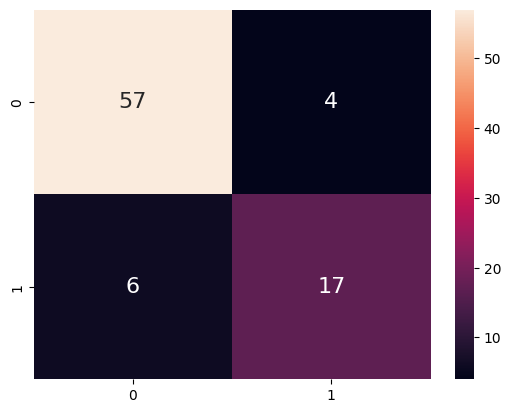

In [20]:
#Montando a matriz de confusão 
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

classes = np.unique(y_verdadeiro)
print(classes)
cm = confusion_matrix(y_verdadeiro, y_previsto, labels=classes)
df_conf = pd.DataFrame(cm, classes, classes)
sns.heatmap(df_conf, annot=True, annot_kws={"size": 16})

## Conclusão

Após realizar a seleção de atributos, necessária dado o número de features e a natureza biológica dos dados, trinou-se um modelo classificador. Esse modelo teve seus hiperparâmetros otimizados com foco na métrica f1, que leva em conta as métricas de _recall_ e _precisão_. Como resultado final, o modelo não passou dos 90% em acurácia, ficando em 88%. Além disso, a métrica f1 atingiu o máximo de 77%, pouco se considerado que este modelo tem foco na área da saúde. Em parte, a maior acurácia reflete um dataset desbalanceado, com mais dados de controle (0) do que dados de Impaired (1)

## Referências

1. Conceito de hiperparâmetro e otimizaçõa de hiperparâmetros: https://www.ibm.com/br-pt/think/topics/hyperparameter-tuning